In [ ]:
# !pip install -U --no-cache-dir gdown --pre
# !gdown --id 1-3c1uHL_uiqToeX4Pq90ijidBw1aDp9I


In [ ]:

# !unzip dataset_mask.zip

In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset.git

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd
from glob2 import glob

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## DataLoader

In [ ]:
label_dict = {
    'cat': 0,
    'dog': 1
}
class MaskDataset(Dataset):
  def __init__(self, df, transform=None):
    self.transform = transform
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = row['img_path']
    img = cv2.imread(img_path)
    label = label_dict[img_path.split("/")[-1].split(".")[0]]
    if self.transform is not None:
      img = self.transform(img)
    return img_path,img, label


In [ ]:
class convertToTensor:
  def __init__(self):
    pass

  def __call__(self, sample):
    print(type(sample))
    image, label = sample

    # opencv image: H x W x C
    # torch image: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label)
    return (image, label)

In [ ]:
transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((384, 384))
])

###############
# Data MNIST
###############
# train_dataset = datasets.MNIST(root='/content',train=True, transform=transform, download=True)
# val_dataset = datasets.MNIST(root='/content', train=False, transform=transform)

###############
# Data Dog-cat
###############

lst_imgs = glob(f"/content/small_dog_cat_dataset/train/**/*.jpg")
lst_img_test = glob(f"/content/small_dog_cat_dataset/test/**/*.jpg")
train_df = pd.DataFrame(lst_imgs)
train_df.columns = ['img_path']

test_df = pd.DataFrame(lst_img_test)
test_df.columns = ['img_path']
# train_df, val_df = train_test_split(df,test_size = 0.2, random_state=42)

train_dataset = MaskDataset(train_df, transform)
val_dataset = MaskDataset(test_df, transform)

In [ ]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(dataset = val_dataset, batch_size = 16, shuffle = True)

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, image_size, patch_size, in_channels=3, embed_dims=768):
    super().__init__()
    self.image_size = image_size

    ###############
    # Data Dog-cat
    ###############
    # self.patch_size = patch_size 
    # self.n_patches = (image_size // patch_size) ** 2

    ###############
    # Data MNIST
    ###############
    self.patch_size = (image_size//4, image_size//2)
    self.n_patches = (image_size // self.patch_size[0])*((image_size // self.patch_size[1]))


    # convolutional layer that does both the splitting into patches and their embedding 
    self.cv2D_layer = nn.Conv2d(in_channels, embed_dims, kernel_size=self.patch_size, stride=self.patch_size)
  
  def forward(self, x):
    '''
      input: X tensor - Shape: (n_samples, in_chans, image_size, image_size).
      output: tensor - Shape: (n_samples, n_patches, embed_dim)
    '''
    x = self.cv2D_layer(x) # Shape: (n_samples, embed_dims, patch_size // 2, patch_size // 2)

    # print('patch:',self.patch_size)
    # print('patch:',x.shape)
    x = x.flatten(2) # Shape: (n_samples, embed_dims, n_patches)
    # print('patch:',x.shape)
    x = x.transpose(1, 2) # Shape: (n_samples, n_patches, embed_dims)
    # print('patch:',x.shape)

    return x

In [ ]:
class Attention(nn.Module):
  def __init__(self, dim, n_heads=12, qkv_bias=True, drop_attn_ratio=0., drop_ratio=0.):
    super().__init__()
    self.n_heads = n_heads 
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5 
    
    self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(drop_attn_ratio)
    self.fc = nn.Linear(dim, dim)
    self.fc_drop = nn.Dropout(drop_ratio)
  
  def forward(self, x):
    '''
      input: Shape: (n_samples, n_patches + 1, dim)
      output: (n_samples, n_patches + 1, dim)
    '''
    n_samples, n_token, dim = x.shape 
    if dim != self.dim:
      raise ValueError 
    
    qkv = self.qkv(x) # shape: (n_samples, n_patches+1, dim*3)
    qkv = qkv.reshape(n_samples, n_token, 3, self.n_heads, self.head_dim) # shape: (n_samples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4) # shape (3, n_samples, n_heads, n_patches+1, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)  # shape: (n_samples, n_heads, head_dim, n_patches + 1)
    dot_product = (q @ k_t) * self.scale # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = dot_product.softmax(dim=-1)  # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)
    weighted_avg = attn @ v  # shape: (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # shape: (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # shape: (n_samples, n_patches + 1, dim)
    x = self.fc(weighted_avg)
    x = self.fc_drop(x) 

    return x 

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, drop_ratio=0.):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.activation_func = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.dropout = nn.Dropout(drop_ratio)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)

    return x 

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim, eps=1e-6)
    self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, drop_attn_ratio=dropout_attn_ratio, drop_ratio=dropout_ratio)
    self.norm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)
  
  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, n_classes=2, image_size=384, patch_size=16, in_channels=3, embed_dims=768, depth=12, \
               n_heads=12, mlp_ratio=4., qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.patch_embed = PatchEmbed(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dims=embed_dims)
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dims))
    self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches, embed_dims))
    self.pos_drop = nn.Dropout(dropout_ratio)
    self.blocks = nn.ModuleList(
      [
          TransformerBlock(
            dim = embed_dims,
            n_heads = n_heads,
            mlp_ratio = mlp_ratio,
            qkv_bias = qkv_bias,
            dropout_attn_ratio = dropout_attn_ratio, 
            dropout_ratio = dropout_ratio
          )
          for _ in range(depth)
      ]
    )
    self.norm = nn.LayerNorm(embed_dims, eps=1e-6)
    self.head = nn.Linear(embed_dims, n_classes)
  
  def forward(self, x):
    n_samples = x.shape[0]
    # print(x.shape)
    x = self.patch_embed(x)
    # print(x.shape)
    # print(self.pos_embed.shape)
    cls_token = self.cls_token.expand(n_samples, -1, -1)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dims)
    x = x + self.pos_embed  
    x = self.pos_drop(x)
    for block in self.blocks:
      x = block(x)
    x = self.norm(x)
    cls_token_final = x[:, 0] 
    x = self.head(cls_token_final)

    return x 


In [ ]:
model = VisionTransformer(10, in_channels=1).to(device)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

## TRAIN

In [ ]:
from tqdm import tqdm
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        print(outputs)
        cv2.imwrite('/content', images[0].detach().cpu().numpy())
        a
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    valid_loss_min = np.Inf
    # train model
    for epoch in tqdm(range(0, epochs)):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
            torch.save(model, 'model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0, Train_loss: 0.4017956803609927, Valid_loss: 0.1936138623058796, Train_accuracy: 94.61, Valid_accuracy: 94.36


 20%|██        | 1/5 [06:38<26:35, 398.78s/it]

Validation loss decreased (inf --> 0.193614).  Saving model ...
Epochs: 1, Train_loss: 0.17493759001034, Valid_loss: 0.1876877199560404, Train_accuracy: 94.99166666666666, Valid_accuracy: 94.24


 40%|████      | 2/5 [13:19<19:59, 399.78s/it]

Validation loss decreased (0.193614 --> 0.187688).  Saving model ...
Epochs: 2, Train_loss: 0.12991909601558, Valid_loss: 0.1287177153892815, Train_accuracy: 96.765, Valid_accuracy: 96.00999999999999


 60%|██████    | 3/5 [19:58<13:18, 399.49s/it]

Validation loss decreased (0.187688 --> 0.128718).  Saving model ...
Epochs: 3, Train_loss: 0.10293125080820173, Valid_loss: 0.10895835685916246, Train_accuracy: 97.74000000000001, Valid_accuracy: 96.57


 80%|████████  | 4/5 [26:37<06:39, 399.19s/it]

Validation loss decreased (0.128718 --> 0.108958).  Saving model ...


100%|██████████| 5/5 [33:12<00:00, 398.42s/it]

Epochs: 4, Train_loss: 0.08502172368808339, Valid_loss: 0.11166305014491082, Train_accuracy: 97.72833333333332, Valid_accuracy: 96.47


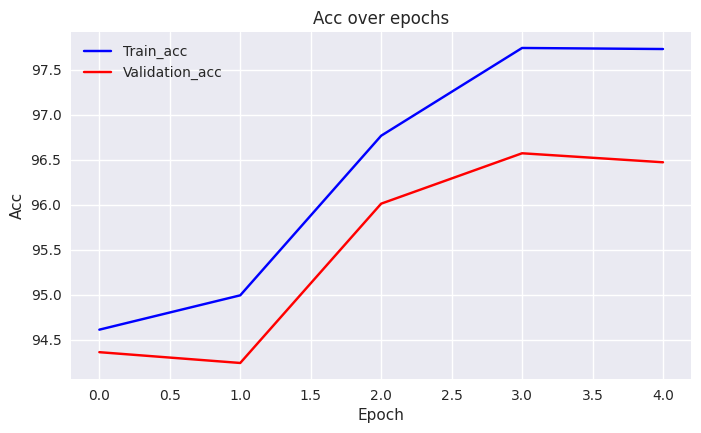

In [ ]:
import warnings
warnings.filterwarnings('ignore')
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_dataloader, test_dataloader, 5, device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0, Train_loss: 0.724820686340332, Valid_loss: 0.7204096144751498, Train_accuracy: 50.1, Valid_accuracy: 50.33333333333333


 20%|██        | 1/5 [06:17<25:08, 377.06s/it]

Validation loss decreased (inf --> 0.720410).  Saving model ...
Epochs: 1, Train_loss: 0.7071200842857361, Valid_loss: 0.6800979877773085, Train_accuracy: 55.900000000000006, Valid_accuracy: 56.00000000000001


 40%|████      | 2/5 [12:25<18:36, 372.16s/it]

Validation loss decreased (0.720410 --> 0.680098).  Saving model ...


 60%|██████    | 3/5 [18:33<12:20, 370.32s/it]

Epochs: 2, Train_loss: 0.6980442271232605, Valid_loss: 0.7339019885188655, Train_accuracy: 50.55, Valid_accuracy: 50.66666666666667


 80%|████████  | 4/5 [24:42<06:09, 369.54s/it]

Epochs: 3, Train_loss: 0.6973594055175781, Valid_loss: 0.6805475730645029, Train_accuracy: 55.85, Valid_accuracy: 57.333333333333336


100%|██████████| 5/5 [30:50<00:00, 370.01s/it]

Epochs: 4, Train_loss: 0.7004751458168029, Valid_loss: 0.6901793809313523, Train_accuracy: 53.449999999999996, Valid_accuracy: 53.333333333333336


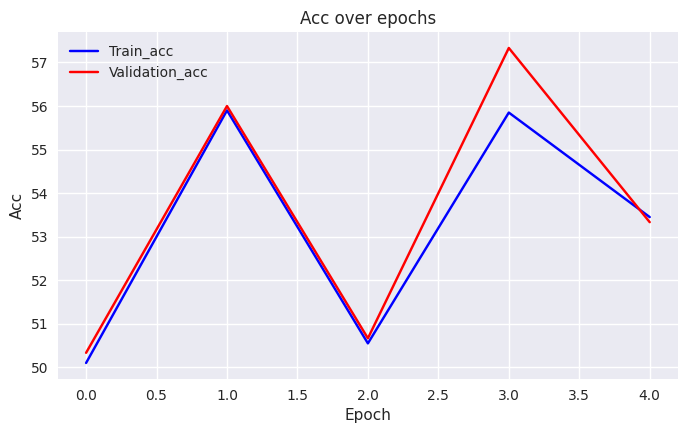

In [ ]:
import warnings
warnings.filterwarnings('ignore')
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_dataloader, test_dataloader, 5, device)

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.4 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
model = timm.create_model(model_name = 'resnet50',pretrained=True)
model = model.to(device)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def validate(valid_loader, model):
    model.eval()
    running_loss = 0

    for img_path,images, labels in valid_loader:
        images = images.to(device)

        # forward pass and record loss
        print(images.shape)
        print(img_path)
        outputs = model(images)
        print(torch.argmax(outputs, axis = 1))
        a
        
    


validate(test_dataloader, model)
del model

torch.Size([16, 3, 384, 384])
('/content/small_dog_cat_dataset/test/dogs/dog.1287.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.10813.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.1547.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.2139.jpg', '/content/small_dog_cat_dataset/test/cats/cat.4888.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.1965.jpg', '/content/small_dog_cat_dataset/test/cats/cat.392.jpg', '/content/small_dog_cat_dataset/test/cats/cat.6535.jpg', '/content/small_dog_cat_dataset/test/cats/cat.2628.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.699.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.8208.jpg', '/content/small_dog_cat_dataset/test/cats/cat.6466.jpg', '/content/small_dog_cat_dataset/test/cats/cat.5565.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.10473.jpg', '/content/small_dog_cat_dataset/test/cats/cat.5688.jpg', '/content/small_dog_cat_dataset/test/dogs/dog.3787.jpg')
tensor([743, 208, 223, 210, 285, 232, 285, 282, 749, 210,

NameError: ignored

In [ ]:
timm.list_models("res*")

['res2net50_14w_8s',
 'res2net50_26w_4s',
 'res2net50_26w_6s',
 'res2net50_26w_8s',
 'res2net50_48w_2s',
 'res2net101_26w_4s',
 'res2next50',
 'resmlp_12_224',
 'resmlp_12_224_dino',
 'resmlp_12_distilled_224',
 'resmlp_24_224',
 'resmlp_24_224_dino',
 'resmlp_24_distilled_224',
 'resmlp_36_224',
 'resmlp_36_distilled_224',
 'resmlp_big_24_224',
 'resmlp_big_24_224_in22ft1k',
 'resmlp_big_24_distilled_224',
 'resnest14d',
 'resnest26d',
 'resnest50d',
 'resnest50d_1s4x24d',
 'resnest50d_4s2x40d',
 'resnest101e',
 'resnest200e',
 'resnest269e',
 'resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200',
 'resnet200d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resn